<a href="https://colab.research.google.com/github/fabricejumel/FNST_google_collab_training/blob/main/243-tflite-selfie-segmentation/243-tflite-selfie-segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Selfie Segmentation using TFLite and OpenVINO

> **Note:** This notebook has been moved to a new branch named "latest". [Click here](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/notebooks/tflite-selfie-segmentation/tflite-selfie-segmentation.ipynb) to get the most updated version of the notebook. This branch is deprecated.

The Selfie segmentation pipeline allows developers to easily separate the background from users within a scene and focus on what matters. Adding cool effects to selfies or inserting your users into interesting background environments has never been easier. Besides photo editing, this technology is also important for video conferencing. It helps to blur or replace the background during video calls.

In this tutorial, we consider how to implement selfie segmentation using OpenVINO. We will use [Multiclass Selfie-segmentation model](https://developers.google.com/mediapipe/solutions/vision/image_segmenter/#multiclass-model) provided as part of [Google MediaPipe](https://developers.google.com/mediapipe) solution.

The Multiclass Selfie-segmentation model is a multiclass semantic segmentation model and classifies each pixel as background, hair, body, face, clothes, and others (e.g. accessories). The model supports single or multiple people in the frame, selfies, and full-body images. The model is based on [Vision Transformer](https://arxiv.org/abs/2010.11929) with customized bottleneck and decoder architecture for real-time performance. More details about the model can be found in [model card](https://storage.googleapis.com/mediapipe-assets/Model%20Card%20Multiclass%20Segmentation.pdf). This model is represented in Tensorflow Lite format. [TensorFlow Lite](https://www.tensorflow.org/lite/guide), often referred to as TFLite, is an open-source library developed for deploying machine learning models to edge devices.

The tutorial consists of following steps:

1. Download the TFLite model and convert it to OpenVINO IR format.
2. Run inference on the image.
3. Run interactive background blurring demo on video.



#### Table of contents:

- [Prerequisites](#Prerequisites)
    - [Install required dependencies](#Install-required-dependencies)
    - [Download pretrained model and test image](#Download-pretrained-model-and-test-image)
- [Convert Tensorflow Lite model to OpenVINO IR format](#Convert-Tensorflow-Lite-model-to-OpenVINO-IR-format)
- [Run OpenVINO model inference on image](#Run-OpenVINO-model-inference-on-image)
    - [Load model](#Load-model)
    - [Prepare input image](#Prepare-input-image)
    - [Run model inference](#Run-model-inference)
    - [Postprocess and visualize inference results](#Postprocess-and-visualize-inference-results)
- [Interactive background blurring demo on video](#Interactive-background-blurring-demo-on-video)
    - [Run Live Background Blurring](#Run-Live-Background-Blurring)



## Prerequisites
[back to top ⬆️](#Table-of-contents:)


### Install required dependencies
[back to top ⬆️](#Table-of-contents:)


In [1]:
import platform

%pip install -q "openvino>=2023.1.0" "opencv-python"

if platform.system() != "Windows":
    %pip install -q "matplotlib>=3.4"
else:
    %pip install -q "matplotlib>=3.4,<3.7"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.0/49.0 MB 13.6 MB/s eta 0:00:00


In [2]:
import urllib.request
urllib.request.urlretrieve(
    url='https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/main/notebooks/utils/notebook_utils.py',
    filename='notebook_utils.py'
);

### Download pretrained model and test image
[back to top ⬆️](#Table-of-contents:)


In [3]:
from pathlib import Path
from notebook_utils import download_file

tflite_model_path = Path("selfie_multiclass_256x256.tflite")
tflite_model_url = "https://storage.googleapis.com/mediapipe-models/image_segmenter/selfie_multiclass_256x256/float32/latest/selfie_multiclass_256x256.tflite"

download_file(tflite_model_url, tflite_model_path)

/usr/local/lib/python3.12/dist-packages/openvino/runtime/__init__.py:10: DeprecationWarning: The `openvino.runtime` module is deprecated and will be removed in the 2026.0 release. Please replace `openvino.runtime` with `openvino`.
  warnings.warn(


selfie_multiclass_256x256.tflite:   0%|          | 0.00/15.6M [00:00<?, ?B/s]

PosixPath('/content/selfie_multiclass_256x256.tflite')

## Convert Tensorflow Lite model to OpenVINO IR format
[back to top ⬆️](#Table-of-contents:)

Starting from the 2023.0.0 release, OpenVINO supports TFLite model conversion. However TFLite model format can be directly passed in `read_model` (you can find examples of this API usage for TFLite in [TFLite to OpenVINO conversion tutorial](../119-tflite-to-openvino/119-tflite-to-openvino.ipynb) and tutorial with [basic OpenVINO API capabilities](../002-openvino-api/002-openvino-api.ipynb)), it is recommended to convert model to OpenVINO Intermediate Representation format to apply additional optimizations (e.g. weights compression to FP16 format). To convert the TFLite model to OpenVINO IR, model conversion Python API can be used. The `ov.convert_model` function accepts a path to the TFLite model and returns the OpenVINO Model class instance which represents this model. The obtained model is ready to use and to be loaded on the device using `compile_model` or can be saved on a disk using the `ov.save_model` function reducing loading time for the next running.
For more information about model conversion, see this [page](https://docs.openvino.ai/2024/openvino-workflow/model-preparation.html). For TensorFlow Lite, refer to the [models support](https://docs.openvino.ai/2024/openvino-workflow/model-preparation/convert-model-tensorflow-lite.html).

In [4]:
import openvino as ov

core = ov.Core()

ir_model_path = tflite_model_path.with_suffix(".xml")

if not ir_model_path.exists():
    ov_model = ov.convert_model(tflite_model_path)
    ov.save_model(ov_model, ir_model_path)
else:
    ov_model = core.read_model(ir_model_path)

W1129 23:10:01.617000 147 torch/export/pt2_archive/_package.py:943] Unable to load package. f must be a buffer or a file ending in .pt2. Instead got {selfie_multiclass_256x256.tflite}
W1129 23:10:01.625000 147 torch/export/__init__.py:451] Ran into the following error when deserializing: [enforce fail at inline_container.cc:176] . file in archive is not in a subdirectory: labels.txt


In [5]:
print(f"Model input info: {ov_model.inputs}")

Model input info: [<Output: names[input_29] shape[1,256,256,3] type: f32>]


Model input is a floating point tensor with shape [1, 256, 256, 3] in `N, H, W, C` format, where

* `N` - batch size, number of input images.
* `H` - the height of the input image.
* `W` - width of the input image.
* `C` - channels of the input image.

The model accepts images in RGB format normalized in [0, 1] range by division on 255.

In [6]:
print(f"Model output info: {ov_model.outputs}")

Model output info: [<Output: names[Identity] shape[1,256,256,6] type: f32>]


Model output is a floating point tensor with the similar format and shape, except number of channels - 6 that represents number of supported segmentation classes: background, hair, body skin, face skin, clothes, and others. Each value in the output tensor represents of probability that the pixel belongs to the specified class. We can use the `argmax` operation to get the label with the highest probability for each pixel.

## Run OpenVINO model inference on image
[back to top ⬆️](#Table-of-contents:)

Let's see the model in action. For running the inference model with OpenVINO we should load the model on the device first. Please use the next dropdown list for the selection inference device.

### Load model
[back to top ⬆️](#Table-of-contents:)


In [7]:
import ipywidgets as widgets

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)

device

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

In [8]:
compiled_model = core.compile_model(ov_model, device.value)

### Prepare input image
[back to top ⬆️](#Table-of-contents:)

The model accepts an image with size 256x256, we need to resize our input image to fit it in the model input tensor. Usually, segmentation models are sensitive to proportions of input image details, so preserving the original aspect ratio and adding padding can help improve segmentation accuracy, we will use this pre-processing approach. Additionally, the input image is represented as an RGB image in UINT8 ([0, 255] data range), we should normalize it in [0, 1].

In [9]:
import cv2
import numpy as np
from notebook_utils import load_image

# Read input image and convert it to RGB
test_image_url = "https://user-images.githubusercontent.com/29454499/251036317-551a2399-303e-4a4a-a7d6-d7ce973e05c5.png"
img = load_image(test_image_url)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Preprocessing helper function
def resize_and_pad(image:np.ndarray, height:int = 256, width:int = 256):
    """
    Input preprocessing function, takes input image in np.ndarray format,
    resizes it to fit specified height and width with preserving aspect ratio
    and adds padding on bottom or right side to complete target height x width rectangle.

    Parameters:
      image (np.ndarray): input image in np.ndarray format
      height (int, *optional*, 256): target height
      width (int, *optional*, 256): target width
    Returns:
      padded_img (np.ndarray): processed image
      padding_info (Tuple[int, int]): information about padding size, required for postprocessing
    """
    h, w = image.shape[:2]
    if h < w:
        img = cv2.resize(image, (width, np.floor(h / (w / width)).astype(int)))
    else:
        img = cv2.resize(image, (np.floor(w / (h / height)).astype(int), height))

    r_h, r_w = img.shape[:2]
    right_padding = width - r_w
    bottom_padding = height - r_h
    padded_img = cv2.copyMakeBorder(img, 0, bottom_padding, 0, right_padding, cv2.BORDER_CONSTANT)
    return padded_img, (bottom_padding, right_padding)

# Apply preprocessig step - resize and pad input image
padded_img, pad_info = resize_and_pad(np.array(img))

# Convert input data from uint8 [0, 255] to float32 [0, 1] range and add batch dimension
normalized_img = np.expand_dims(padded_img.astype(np.float32) / 255, 0)

### Run model inference
[back to top ⬆️](#Table-of-contents:)


In [10]:
out = compiled_model(normalized_img)[0]

### Postprocess and visualize inference results
[back to top ⬆️](#Table-of-contents:)

The model predicts segmentation probabilities mask with the size 256 x 256, we need to apply postprocessing to get labels with the highest probability for each pixel and restore the result in the original input image size. We can interpret the result of the model in different ways, e.g. visualize the segmentation mask, apply some visual effects on the selected background (remove, replace it with any other picture, blur it) or other classes (for example, change the color of person's hair or add makeup).

In [11]:
from typing import Tuple
from notebook_utils import segmentation_map_to_image, SegmentationMap, Label

# helper for visualization segmentation labels
labels = [
    Label(index=0, color=(192, 192, 192), name="background"),
    Label(index=1, color=(128, 0, 0), name="hair"),
    Label(index=2, color=(255, 229, 204), name="body skin"),
    Label(index=3, color=(255, 204, 204), name="face skin"),
    Label(index=4, color=(0, 0, 128), name="clothes"),
    Label(index=5, color=(128, 0, 128), name="others"),
]
SegmentationLabels = SegmentationMap(labels)

# helper for postprocessing output mask
def postprocess_mask(out:np.ndarray, pad_info:Tuple[int, int], orig_img_size:Tuple[int, int]):
    """
    Posptprocessing function for segmentation mask, accepts model output tensor,
    gets labels for each pixel using argmax,
    unpads segmentation mask and resizes it to original image size.

    Parameters:
      out (np.ndarray): model output tensor
      pad_info (Tuple[int, int]): information about padding size from preprocessing step
      orig_img_size (Tuple[int, int]): original image height and width for resizing
    Returns:
      label_mask_resized (np.ndarray): postprocessed segmentation label mask
    """
    label_mask = np.argmax(out, -1)[0]
    pad_h, pad_w = pad_info
    unpad_h = label_mask.shape[0] - pad_h
    unpad_w = label_mask.shape[1] - pad_w
    label_mask_unpadded = label_mask[:unpad_h, :unpad_w]
    orig_h, orig_w = orig_img_size
    label_mask_resized = cv2.resize(label_mask_unpadded, (orig_w, orig_h), interpolation=cv2.INTER_NEAREST)
    return label_mask_resized

# Get info about original image
image_data = np.array(img)
orig_img_shape = image_data.shape

# Specify background color for replacement
BG_COLOR = (192, 192, 192)

# Blur image for backgraund blurring scenario using Gaussian Blur
blurred_image = cv2.GaussianBlur(image_data, (55, 55), 0)

# Postprocess output
postprocessed_mask = postprocess_mask(out, pad_info, orig_img_shape[:2])

# Get colored segmentation map
output_mask = segmentation_map_to_image(postprocessed_mask, SegmentationLabels.get_colormap())

# Replace background on original image
# fill image with solid background color
bg_image = np.full(orig_img_shape, BG_COLOR, dtype=np.uint8)

# define condition mask for separation background and foreground
condition = np.stack((postprocessed_mask,) * 3, axis=-1) > 0
# replace background with solid color
output_image = np.where(condition, image_data, bg_image)
# replace background with blurred image copy
output_blurred_image = np.where(condition, image_data, blurred_image)

Visualize obtained result

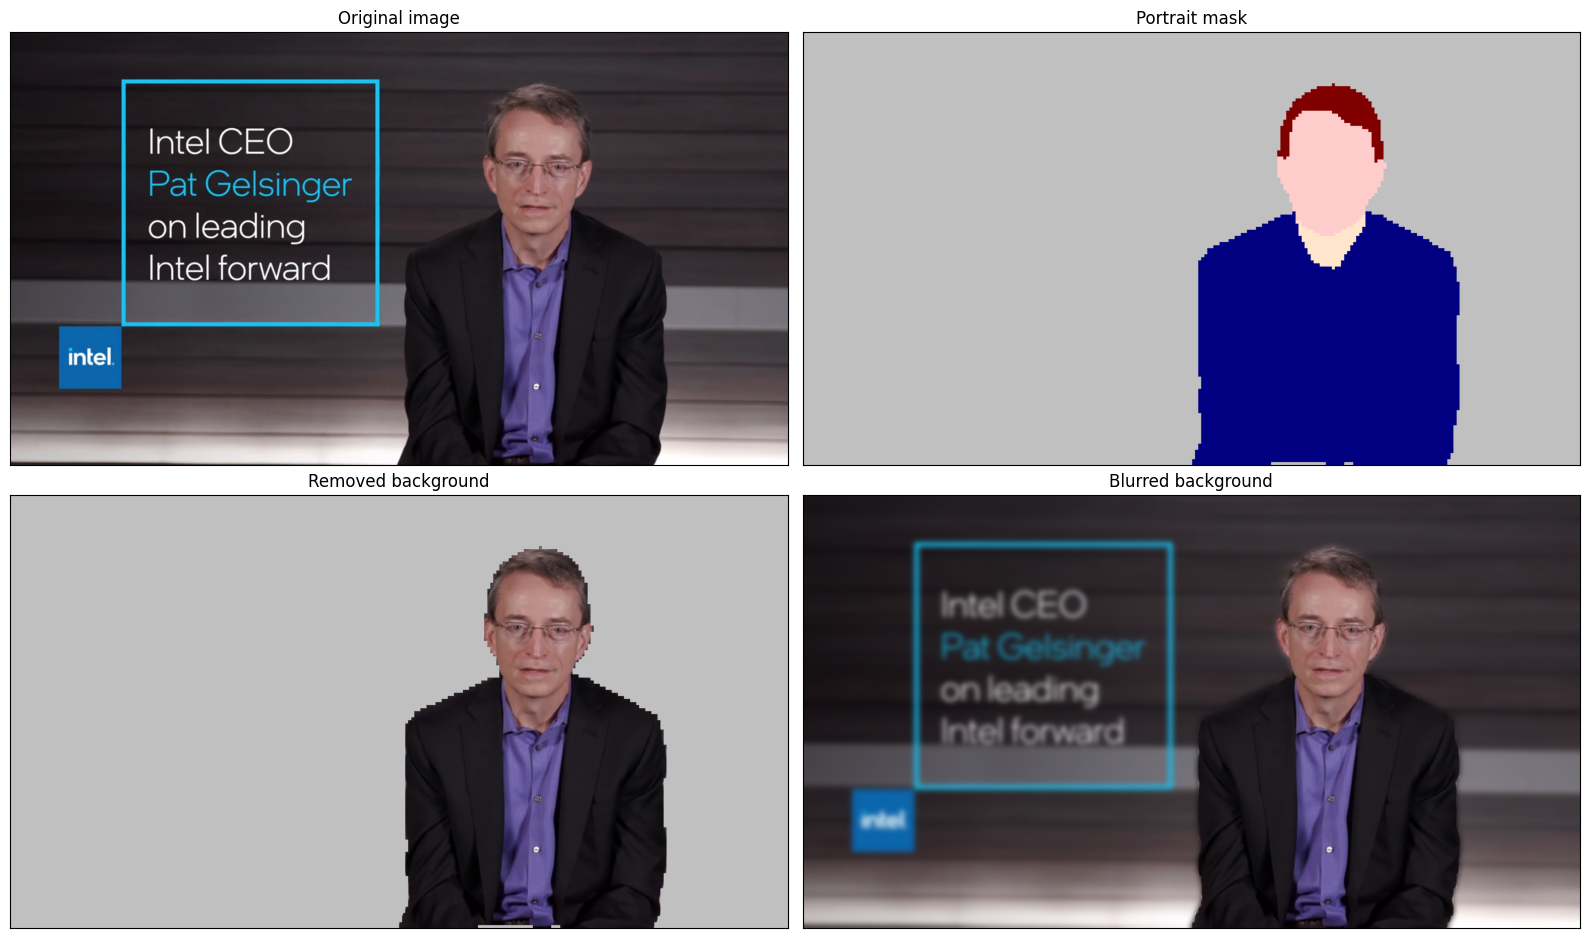

In [12]:
import matplotlib.pyplot as plt

titles = ["Original image", "Portrait mask", "Removed background", "Blurred background"]
images = [image_data, output_mask, output_image, output_blurred_image]
figsize = (16, 16)
fig, axs = plt.subplots(2, 2, figsize=figsize, sharex='all', sharey='all')
fig.patch.set_facecolor('white')
list_axes = list(axs.flat)
for i, a in enumerate(list_axes):
    a.set_xticklabels([])
    a.set_yticklabels([])
    a.get_xaxis().set_visible(False)
    a.get_yaxis().set_visible(False)
    a.grid(False)
    a.imshow(images[i].astype(np.uint8))
    a.set_title(titles[i])
fig.subplots_adjust(wspace=0.0, hspace=-0.8)
fig.tight_layout()

## Interactive background blurring demo on video
[back to top ⬆️](#Table-of-contents:)

The following code runs model inference on a video:

In [13]:
import collections
import time
from IPython import display
from typing import Union

from notebook_utils import VideoPlayer


# Main processing function to run background blurring
def run_background_blurring(source:Union[str, int] = 0, flip:bool = False, use_popup:bool = False, skip_first_frames:int = 0, model:ov.Model = ov_model, device:str = "CPU"):
    """
    Function for running background blurring inference on video
    Parameters:
      source (Union[str, int], *optional*, 0): input video source, it can be path or link on video file or web camera id.
      flip (bool, *optional*, False): flip output video, used for front-camera video processing
      use_popup (bool, *optional*, False): use popup window for avoid flickering
      skip_first_frames (int, *optional*, 0): specified number of frames will be skipped in video processing
      model (ov.Model): OpenVINO model for inference
      device (str): inference device
    Returns:
      None
    """
    player = None
    compiled_model = core.compile_model(model, device)
    try:
        # Create a video player to play with target fps.
        player = VideoPlayer(
            source=source, flip=flip, fps=30, skip_first_frames=skip_first_frames
        )
        # Start capturing.
        player.start()
        if use_popup:
            title = "Press ESC to Exit"
            cv2.namedWindow(
                winname=title, flags=cv2.WINDOW_GUI_NORMAL | cv2.WINDOW_AUTOSIZE
            )

        processing_times = collections.deque()
        while True:
            # Grab the frame.
            frame = player.next()
            if frame is None:
                print("Source ended")
                break
            # If the frame is larger than full HD, reduce size to improve the performance.
            scale = 1280 / max(frame.shape)
            if scale < 1:
                frame = cv2.resize(
                    src=frame,
                    dsize=None,
                    fx=scale,
                    fy=scale,
                    interpolation=cv2.INTER_AREA,
                )
            # Get the results.
            input_image, pad_info = resize_and_pad(frame, 256, 256)
            normalized_img = np.expand_dims(input_image.astype(np.float32) / 255, 0)

            start_time = time.time()
            # model expects RGB image, while video capturing in BGR
            segmentation_mask = compiled_model(normalized_img[:, :, :, ::-1])[0]
            stop_time = time.time()
            blurred_image = cv2.GaussianBlur(frame, (55, 55), 0)
            postprocessed_mask = postprocess_mask(segmentation_mask, pad_info, frame.shape[:2])
            condition = np.stack((postprocessed_mask,) * 3, axis=-1) > 0
            frame = np.where(condition, frame, blurred_image)
            processing_times.append(stop_time - start_time)
            # Use processing times from last 200 frames.
            if len(processing_times) > 200:
                processing_times.popleft()

            _, f_width = frame.shape[:2]
            # Mean processing time [ms].
            processing_time = np.mean(processing_times) * 1000
            fps = 1000 / processing_time
            cv2.putText(
                img=frame,
                text=f"Inference time: {processing_time:.1f}ms ({fps:.1f} FPS)",
                org=(20, 40),
                fontFace=cv2.FONT_HERSHEY_COMPLEX,
                fontScale=f_width / 1000,
                color=(255, 0, 0),
                thickness=1,
                lineType=cv2.LINE_AA
            )
            # Use this workaround if there is flickering.
            if use_popup:
                cv2.imshow(winname=title, mat=frame)
                key = cv2.waitKey(1)
                # escape = 27
                if key == 27:
                    break
            else:
                # Encode numpy array to jpg.
                _, encoded_img = cv2.imencode(
                    ext=".jpg", img=frame, params=[cv2.IMWRITE_JPEG_QUALITY, 100]
                )
                # Create an IPython image.
                i = display.Image(data=encoded_img)
                # Display the image in this notebook.
                display.clear_output(wait=True)
                display.display(i)
    # ctrl-c
    except KeyboardInterrupt:
        print("Interrupted")
    # any different error
    except RuntimeError as e:
        print(e)
    finally:
        if player is not None:
            # Stop capturing.
            player.stop()
        if use_popup:
            cv2.destroyAllWindows()

### Run Live Background Blurring
[back to top ⬆️](#Table-of-contents:)

Use a webcam as the video input. By default, the primary webcam is set with `source=0`. If you have multiple webcams, each one will be assigned a consecutive number starting at 0. Set `flip=True` when using a front-facing camera. Some web browsers, especially Mozilla Firefox, may cause flickering. If you experience flickering, set `use_popup=True`.

>**NOTE**: To use this notebook with a webcam, you need to run the notebook on a computer with a webcam. If you run the notebook on a remote server (for example, in Binder or Google Colab service), the webcam will not work. By default, the lower cell will run model inference on a video file. If you want to try to live inference on your webcam set `WEBCAM_INFERENCE = True`

In [14]:
WEBCAM_INFERENCE = False

if WEBCAM_INFERENCE:
    VIDEO_SOURCE = 0  # Webcam
else:
    VIDEO_SOURCE = "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/video/CEO%20Pat%20Gelsinger%20on%20Leading%20Intel.mp4"

Select device for inference:

In [15]:
device

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

Run:

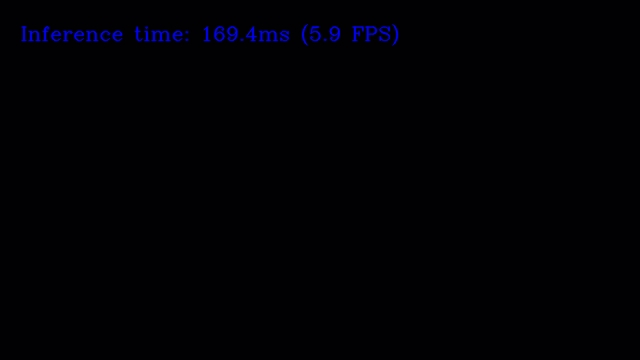

Source ended


In [16]:
run_background_blurring(source=VIDEO_SOURCE, device=device.value)